# Atmospheric Effects on DORIS

## Troposphere

In [5]:
#Section 1 - Imports

#imports
import datetime
import attotime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from os.path import join

#DSO modules
from dsoclasses.doris.algorithms import beacon_nominal_frequency
from dsoclasses.rinex.doris.rinex import DorisRinex
from dsoclasses.time.pyattotime import at2pt, fsec2asec
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
from dsoclasses.gnss import algorithms as alg
from dsoclasses.troposphere.vmf3 import SiteVmf3
from dsoclasses.sinex import sinex

# Section – Define File Paths
data_path = "/home/xanthos/Software/AcademicSoftware/data"
drinex = join(data_path, "s6arx24001.001")
dpod = join(data_path, "dpod2020_041.snx")
dsp3 = join(data_path, "ssas6a20.b23357.e24001.DG_.sp3.001")
vmf3_data = join(data_path, "y2024.vmf3_d")

# Section 2.2 - Load Orbit Data + Initialize Interpolator 
intrp = interpolator.Sp3Interpolator.from_sp3(dsp3, ['L'], interval_in_sec=310, min_data_pts=10, itype='Barycentric')

# the sp3 only holds one satellite, let's get its id:
assert len(list(intrp._interpolators.keys())) == 1
satsp3_id = list(intrp._interpolators.keys())[0]

#Section 2.3 - Intitialize DorisRinex and select a beacon (Dionysos/DIOB)
rnx = DorisRinex(drinex)

# choose a station and get coordinates (DIOB DORIS beacon)
site_id = 'DIOB'

# approx. DIOB coordinates
diob_crd = sinex.extract_sinex_coordinates(dpod, [site_id], rnx.time_first_obs, True)[site_id]
diob_xyz = np.array([diob_crd['X'], diob_crd['Y'], diob_crd['Z']])

lat, lon, hgt = transformations.car2ell(*diob_xyz)
Rt = transformations.geodetic2lvlh(lat, lon)
R = Rt.transpose()

def azele(rsat, rsta):
    enu = R @ (rsat - rsta)
    r  = np.linalg.norm(enu)
    az = np.arctan2(enu[0], enu[1])
    el = np.arcsin(enu[2] / r)
    return r, az, el

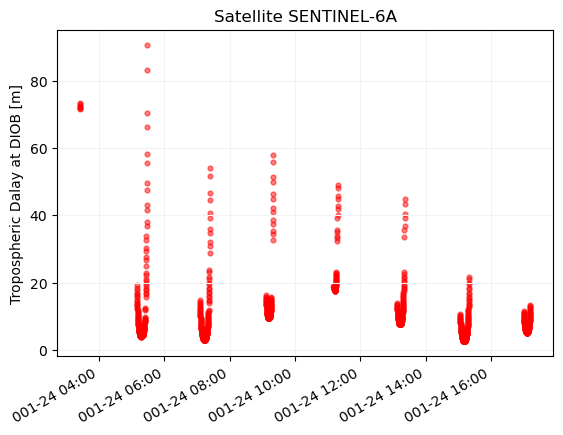

In [12]:
# initialize VMF3 from (DORIS) site data
vmf = SiteVmf3(vmf3_data, ['DIOB'])

# lets store time and range-rate measurements to plot them later on
ts = []; zd = []; elvs = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id('DIOB'):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)
            
            # satellite position
            satx, saty, satz, _ = intrp.sat_at('L40', tai)
            rsat = np.array([satx, saty, satz])

            _, _, el = azele(rsat, diob_xyz)
            dT = vmf.tropo_dealy('DIOB', lat, lon, el, at2pt(tai))
            
            ts.append(tai)
            zd.append(dT)
            elvs.append(np.degrees(el))

plt.scatter([at2pt(ti) for ti in ts], zd, alpha=0.5, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Tropospheric Dalay at DIOB [m]")
plt.title(f"Satellite {rnx.sat_name}")
# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%j-%y %H:%M"))
# auto-rotate date labels for readability
plt.gcf().autofmt_xdate()
plt.show()

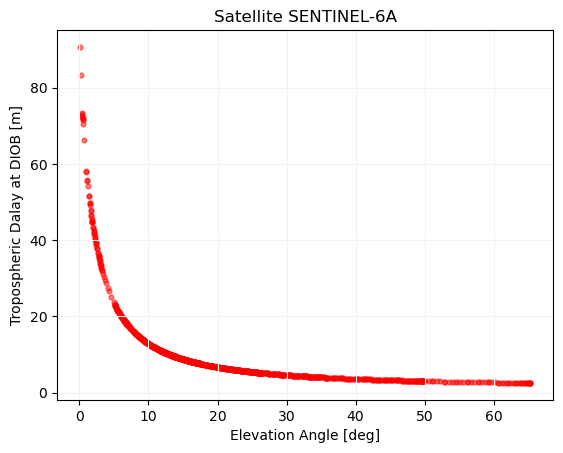

In [15]:
plt.scatter(elvs, zd, alpha=0.5, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Tropospheric Dalay at DIOB [m]")
plt.xlabel(f"Elevation Angle [deg]")
plt.title(f"Satellite {rnx.sat_name}")
plt.show()